# Age And Gender Classification Project

# Introduction
This notebook, presents a project that focuses on the classification of age and 
gender using a dataset of UTKfaces from kaggle. 

Key Aspects:

- **EDA** Get familiar with dataset, making some primary insights.
- **Model Training:** Training a model using pytorch Lightning module, while 
using pretrained architecture from FaceNet
- **Performance Evaluation:** Various metrics are used to evaluate the model's 
performance, ensuring a robust and reliable classification system.
- **Visualization:** Throughout, there are instances of data visualization to 
provide insights into the dataset and model performance.
- **Ethical issues and biases** How model can be biased and where can 
cause ethical concerns

# Exploratory Data Analysis

In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from torchvision import transforms
import facenet_pytorch
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import wandb
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             accuracy_score, precision_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set(style="whitegrid")

In [2]:
path = "D:\\TuringC\\4 Deep Learning\\3 Sprint\\CAPSTONE\\data\\UTKFace\\"
image_files = [f for f in os.listdir(path)]

print(f'There are {len(image_files)} images in path directory.')
image_files[0:5]

There are 23708 images in path directory.


['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg']

Our image name consists age(first number), gender(second number) and ethnicity.
To begin with, we should create dataframe with extracted image name, age,
gender and size.

In [3]:
df = []

for file_name in image_files:
    splits = file_name.split('_')
    age = int(splits[0])
    gender = 'Male' if int(splits[1]) == 0 else 'Female'
    image_path = path + file_name

    # Open the image to get its size
    img = Image.open(image_path)
    width, height = img.size

    df.append({'file_name': file_name,
               'age': age,
               'gender': gender,
               'image_path': image_path,
               'width': width,
               'height': height})

df = pd.DataFrame(df)

In [4]:
df.head()

file_name  age  gender  \
0  100_0_0_20170112213500903.jpg.chip.jpg  100    Male   
1  100_0_0_20170112215240346.jpg.chip.jpg  100    Male   
2  100_1_0_20170110183726390.jpg.chip.jpg  100  Female   
3  100_1_0_20170112213001988.jpg.chip.jpg  100  Female   
4  100_1_0_20170112213303693.jpg.chip.jpg  100  Female   

                                          image_path  width  height  
0  D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\d...    200     200  
1  D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\d...    200     200  
2  D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\d...    200     200  
3  D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\d...    200     200  
4  D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\d...    200     200

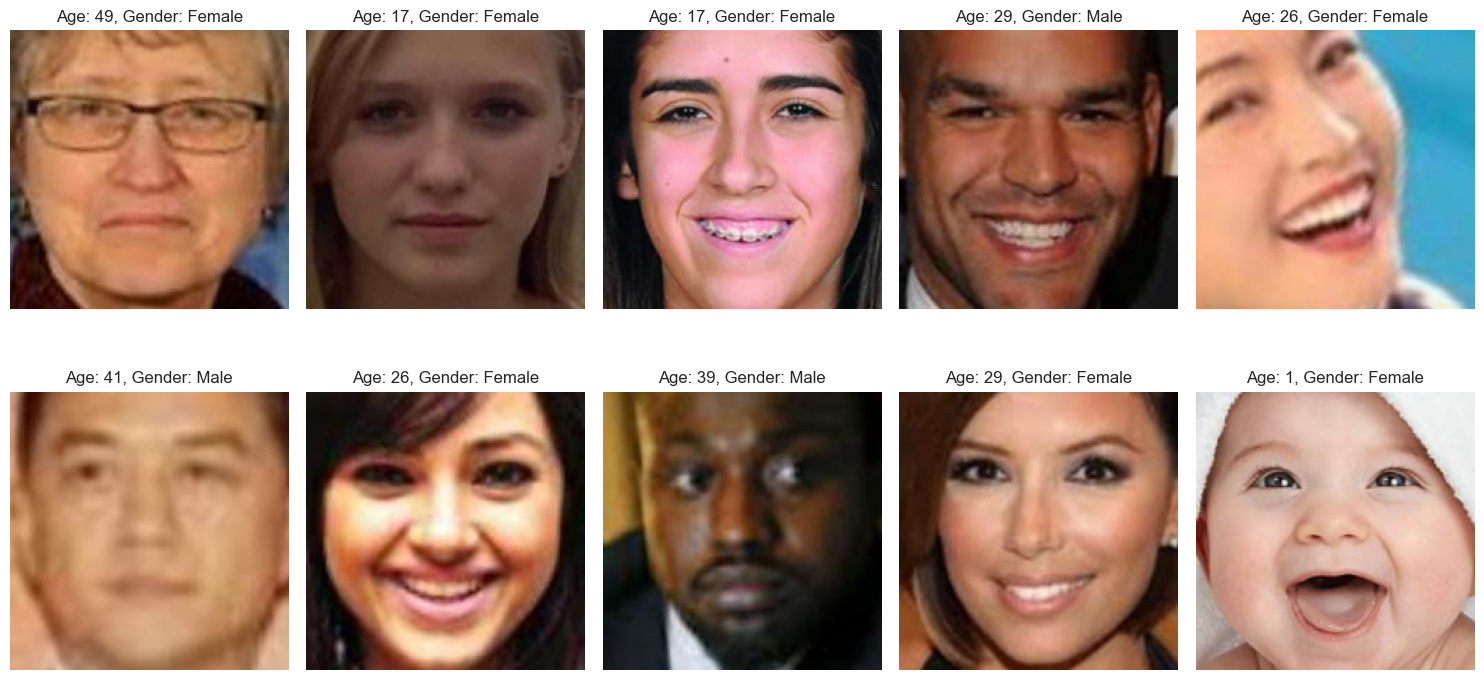

In [5]:
np.random.seed(42)

sample_images = df.sample(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 8)) 
axes = axes.flatten()

for i, row in enumerate(sample_images.itertuples()):
    age = row.age
    gender = row.gender
    image_path = row.image_path
    
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Age: {age}, Gender: {gender}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


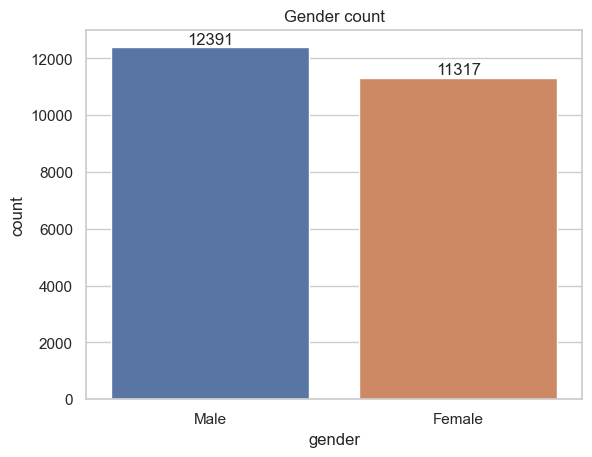

In [6]:
ax = sns.countplot(x='gender', data=df)
plt.title('Gender count')
ax.bar_label(ax.containers[0])
plt.show()

We can see that we have quite well balanced genders in our dataset. We 
should check age distribution.

In [7]:
df['age'].describe()

count    23708.000000
mean        33.303484
std         19.886112
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

D:\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


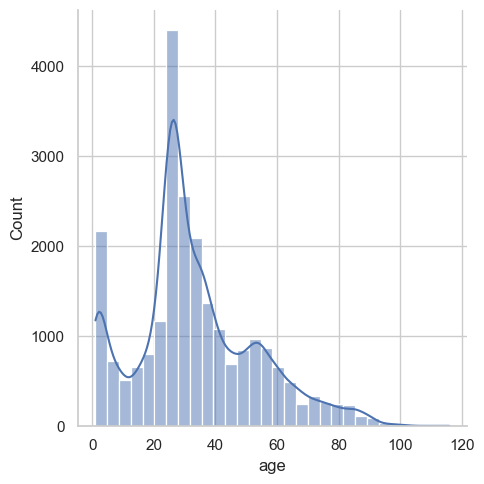

In [8]:
sns.displot(df['age'], bins=30, kde=True)
plt.show();

We have right skewed distribution. There are a huge spike in age of 26 model
 can overfit to these faces. And very few instances over 90 years old.

In [9]:
df['age'].value_counts(ascending=False)

age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: count, Length: 104, dtype: int64

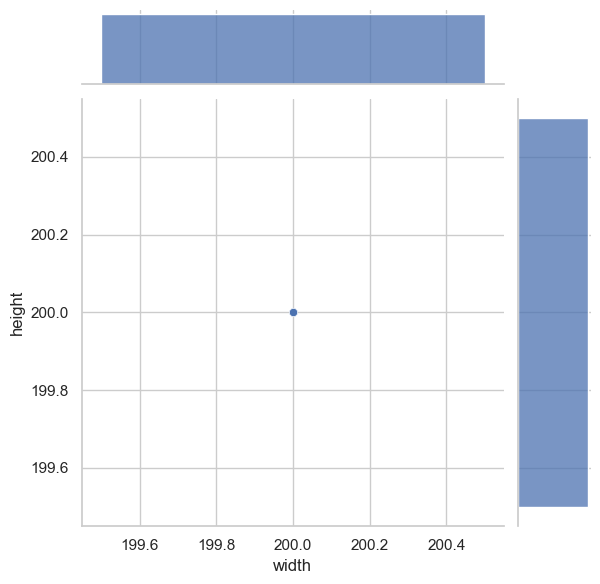

In [10]:
sns.jointplot(x='width', y='height', data=df, kind='scatter')

All our images is sized 200x200 no anomalies detected. We should remove 
instances over 90years old as our model couldn't learn anything from them. 
And undersample age 26 to balance our dataset a little bit.

In [11]:
df_filtered = df[(df['age'] < 90) & (df['age'] != 26)]

df_age_26_half = df[df['age'] == 26].sample(frac=0.5)

df_final = pd.concat([df_filtered, df_age_26_half])

In [12]:
df_final.shape

(22440, 6)

D:\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


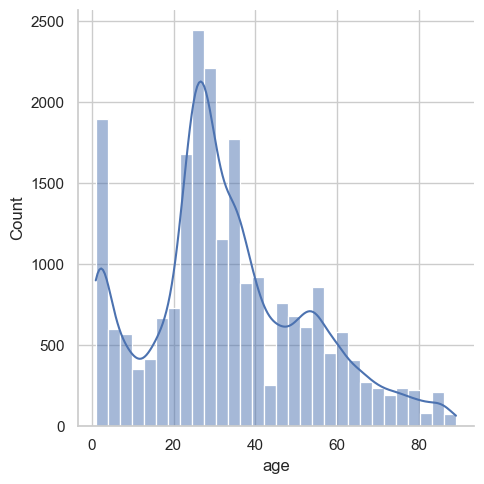

In [13]:
sns.displot(df_final['age'], bins=30, kde=True)
plt.show();

Still there are spike in distribution in age around 30, but it looks better.

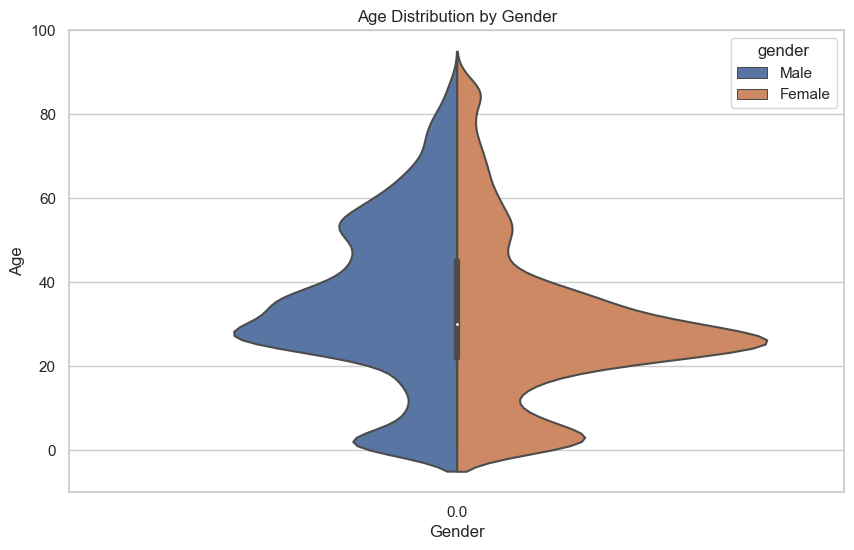

In [14]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=np.zeros(df_final.shape[0]),
               y="age",
               hue='gender',
               data=df_final,
               split=True)

plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Show the plot
plt.show()

From a graph above we can see that we have move female instances in age 
20-30. And there are more male over 40year old. 

# Model Training

In this part we are going to prepare data for our model, construct data 
loaders and models.
To begin with we have to split our data to training, validation and test 
sets in ratio 7:1,5:1,5

In [15]:
df_final['gender'] = df_final['gender'].map({'Male': 0, 'Female': 1})
X = df_final['image_path']
y = df_final[['gender', 'age']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y['age'],
                                                    random_state=42)

# Split train+validation into train and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.5,
                                                stratify=y_temp['age'],
                                                random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15708,)
(3366,)
(3366,)


We should check if age and gender equally distributed after data splitting.

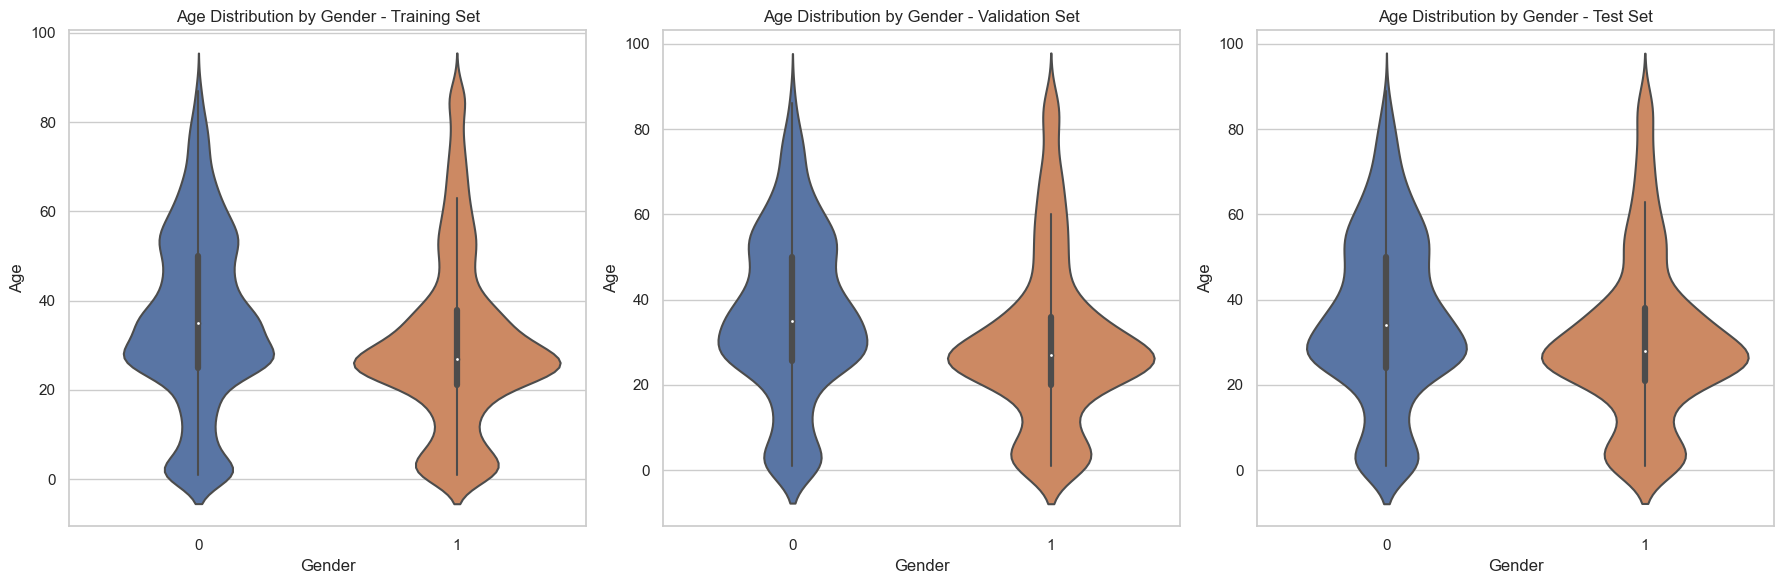

In [16]:
plt.figure(figsize=(18, 6))
titles = ['Training Set', 'Validation Set', 'Test Set']
data_sets = [y_train, y_val, y_test]

for i, data in enumerate(data_sets, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x="gender", 
                   y="age", 
                   data=data, 
                   split=True)
    plt.title(f'Age Distribution by Gender - {titles[i-1]}')
    plt.xlabel('Gender')
    plt.ylabel('Age')

plt.tight_layout()
plt.show()


# Preparing data

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Now, we need to set up transformers and data loaders for the training, 
validation, and test sets. Since we will be using a pretrained architecture 
from FaceNet, we will configure our transformers accordingly.

In [18]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths.iloc[index])
        label = np.array(self.labels.iloc[index])

        if self.transform is not None:
            image = self.transform(image)

        return image, torch.from_numpy(label)

facenet_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

facenet_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = FaceDataset(X_train, y_train, transform=facenet_transform_train)
val_dataset = FaceDataset(X_val, y_val, transform=facenet_transform)
test_dataset = FaceDataset(X_test, y_test, transform=facenet_transform)

batch_size = 32

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         pin_memory=True)

After setting up our loaders, we will create our model class with a core 
feature extractor, where convolutional layers will be shared by both 
classification and regression heads. For gender classification and age 
regression, we will create separate heads with fully connected layers.



Several tests of different architectures were made outside this notebook. 
There are some results:

|   | model | age\_mse | age\_mae | gender\_acc | gender\_prec | gender\_f1 |
|:--| :--- | :--- | :--- | :--- | :--- | :--- |
| 0 | model | 381.328697 | 15.355766 | 0.849941 | 0.838282 | 0.838335 |
| 1 | model\_1 | 421.614026 | 16.453466 | 0.843062 | 0.931429 | 0.803016 |
| 2 | model\_2 | 62.498135 | 5.579674 | 0.907921 | 0.928857 | 0.893337 |
| 3 | model\_3 | 351.206899 | 14.629742 | 0.865173 | 0.946853 | 0.833410 |
| 4 | model\_4 | 142.264048 | 9.040000 | 0.880700 | 0.913230 | 0.861205 |
| 5 | model\_5 | 70.841802 | 6.055323 | 0.905562 | 0.953854 | 0.888231 |

- model - custom architecture with uncertain weighted sum
- model_1 - custom architecture with weighted sum 0.01
- model_2 - resnet34 with weighted sum
- model_3 - custom architecture with weighted sum 0.001
- model_4 - facenet vggface2 with uncertain weighted sum, freezed layers
- model_5 - facenet vggface2 with uncertain weighted sum, unfreezed 1layer

After trying different techniques I will use pretrained InceptionResnetV1
architecture from FaceNet for feature extraction. This was trained on 
vggface2 dataset with over 3millions images, which are similar for our data.


In [19]:
facenet_architecture = facenet_pytorch.InceptionResnetV1(pretrained='vggface2').train()
total_layers = len(list(facenet_architecture.children()))
total_layers

18

There are 18 layers modules in this architecture(15 without linear FC layers)
, as we have data similar as architecture was trained on, and have almost 16k 
training images, we can try to unfreeze more layers gradually.

In [30]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, batch_size=16,
                 loss_balance=0.01,
                 learning_rate=1e-4):
        super(MultiTaskModel, self).__init__()
        self.batch_size = batch_size
        self.loss_balance = loss_balance
        self.learning_rate = learning_rate

        facenet = facenet_pytorch.InceptionResnetV1(pretrained='vggface2').train()

        modules = list(facenet.children())[:-3] # Remove the last FC layers
        self.feature_extractor = nn.Sequential(*modules)
        print(f'Layers left after removing last FC '
              f'{len(list(self.feature_extractor.children()))}')

        # Freeze all layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        flattened_size = 1792

        # Define task-specific layers for age regression
        self.age_regressor = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

        # Define task-specific layers for gender classification
        self.gender_classifier = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

        self.gender_loss_func = nn.BCEWithLogitsLoss()
        self.age_loss_func = nn.MSELoss()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)

        age = self.age_regressor(x)
        gender = self.gender_classifier(x)

        return gender, age


    def training_step(self, batch, batch_idx):
        images, labels = batch
        gender_labels = labels[:, 0]
        age_labels = labels[:, 1]

        # Move data to the same device as the model
        images = images.to(self.device)
        gender_labels = gender_labels.to(self.device).float()
        age_labels = age_labels.to(self.device).float()

        gender_pred, age_pred = self(images)
        gender_pred = gender_pred.squeeze(1)
        age_pred = age_pred.squeeze(1)

        # Calculate loss for each task
        age_loss = self.age_loss_func(age_pred, age_labels)
        gender_loss = self.gender_loss_func(gender_pred, gender_labels)

        combined_loss = ((self.loss_balance * age_loss)
                         + ((1 - self.loss_balance) * gender_loss))

        # Calculate accuracy
        gender_pred_binary = torch.sigmoid(gender_pred) > 0.5
        correct_predictions = gender_pred_binary == gender_labels.int()
        accuracy = (correct_predictions.sum().float() / gender_labels.size(0)
                    +0.0001)

        self.log('train_gender_acc', accuracy)
        self.log('train_age_loss', age_loss)
        self.log('train_gender_loss', gender_loss)
        self.log('train_loss_combined', combined_loss, on_step=True,
                 on_epoch=True, prog_bar=True)

        return combined_loss


    def validation_step(self, batch, batch_idx):
        images, labels = batch
        gender_labels = labels[:, 0]
        age_labels = labels[:, 1]

        # Move data to the same device as the model
        images = images.to(self.device)
        gender_labels = gender_labels.to(self.device).float()
        age_labels = age_labels.to(self.device).float()

        gender_pred, age_pred = self(images)
        gender_pred = gender_pred.squeeze(1)
        age_pred = age_pred.squeeze(1)

        # Calculate loss for each task
        age_loss = self.age_loss_func(age_pred, age_labels)
        gender_loss = self.gender_loss_func(gender_pred, gender_labels)

        combined_loss = ((self.loss_balance * age_loss)
                         + ((1 - self.loss_balance) * gender_loss))

        # Calculate accuracy
        gender_pred_binary = torch.sigmoid(gender_pred) > 0.5
        correct_predictions = gender_pred_binary == gender_labels.int()
        accuracy = (correct_predictions.sum().float() / gender_labels.size(0)
                    +0.0001)

        self.log('val_gender_acc', accuracy)
        self.log('val_age_loss', age_loss)
        self.log('val_gender_loss', gender_loss)
        self.log('val_combined_loss', combined_loss)


    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate)


    def unfreeze_layer(self, num_layers):
        children = list(self.feature_extractor.children())
        if num_layers < len(children):
            for child in children[-num_layers:]:
                for param in child.parameters():
                    param.requires_grad = True
            print(f'Unfreezed layers: {num_layers}')


    def on_train_epoch_start(self):
        optimizer = self.optimizers()
        if self.current_epoch >= 13:
            optimizer.param_groups[0]['lr'] = 1e-6
            print(f"learning rate set: {optimizer.param_groups[0]['lr']}")
        elif self.current_epoch >= 3:
            optimizer.param_groups[0]['lr'] = 1e-5
            print(f"learning rate set: {optimizer.param_groups[0]['lr']}")
            layers_to_unfreeze = self.current_epoch - 2
            self.unfreeze_layer(layers_to_unfreeze)


    def train_dataloader(self):
        return DataLoader(train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,pin_memory=True)


    def val_dataloader(self):
        return DataLoader(val_dataset,
                          batch_size=self.batch_size,pin_memory=True)

model = MultiTaskModel(batch_size=16,
                       loss_balance=0.01,
                       learning_rate=1e-4)
model.cuda()

Layers left after removing last FC 15


MultiTaskModel(
  (feature_extractor): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [21]:
# Initialize W&B logger
wandb_logger = WandbLogger(project='gender_age_prediction',
                           name='run10_facenet_final_dynLR_bs16')

early_stopping_callback = EarlyStopping(
    monitor='val_combined_loss',
    patience=7,
    mode='min',
    verbose=True,
    min_delta=0.01
)
checkpoint_callback = ModelCheckpoint(
    monitor='val_combined_loss',
    dirpath='my_model/',
    filename='model-{epoch:02d}-{val_combined_loss:.2f}',
    save_top_k=8,
    mode='min',
)

trainer = Trainer(max_epochs=100,
                  logger=wandb_logger,
                  callbacks=[early_stopping_callback, checkpoint_callback],
                  accelerator='gpu')

trainer.fit(model)
wandb_logger.experiment.finish()

wandb: Currently logged in as: gviidas. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\TuringC\4 Deep Learning\3 Sprint\CAPSTONE\my_model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params
--------------------------------------------------------
0 | feature_extractor | Sequential        | 22.6 M
1 | age_regressor     | Sequential        | 237 K 
2 | gender_classifier | Sequential        | 237 K 
3 | gender_loss_func  | BCEWithLogitsLoss | 0     
4 | age_loss_func     | MSELoss           | 0     
--------------------------------------------------------
475 K     Trainable params
22.6 M    Non-trainable params
23.0 M    Total params
92.159    Total estimated mode

Sanity Checking: 0it [00:00, ?it/s]

D:\Anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\Anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved. New best score: 1.452


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.111 >= min_delta = 0.01. New best score: 1.340


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.196 >= min_delta = 0.01. New best score: 1.144


learning rate set: 1e-05
Unfreezed layers: 1


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-05
Unfreezed layers: 2


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.113


learning rate set: 1e-05
Unfreezed layers: 3


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.248 >= min_delta = 0.01. New best score: 0.865


learning rate set: 1e-05
Unfreezed layers: 4


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.143 >= min_delta = 0.01. New best score: 0.722


learning rate set: 1e-05
Unfreezed layers: 5


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.040 >= min_delta = 0.01. New best score: 0.682


learning rate set: 1e-05
Unfreezed layers: 6


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.650


learning rate set: 1e-05
Unfreezed layers: 7


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.612


learning rate set: 1e-05
Unfreezed layers: 8


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-05
Unfreezed layers: 9


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-05
Unfreezed layers: 10


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.599


learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.586


learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

Metric val_combined_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.569


learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

learning rate set: 1e-06


Validation: 0it [00:00, ?it/s]

Monitored metric val_combined_loss did not improve in the last 7 records. Best score: 0.569. Signaling Trainer to stop.


As our model started overfitting over 14epochs, we are going to load model 
from created checkpoint of 14epoch.

In [ ]:
model = (MultiTaskModel.load_from_checkpoint
         ('my_model/model-epoch=14-val_combined_loss=0.57.ckpt'))

torch.save(model, 'run10_facenet_final_dynLR_bs16')

In [39]:
# Create the run object from WandB:
api = wandb.Api()
run = api.run('gviidas/gender_age_prediction/s5sw921i')

# Load logs from wandb API
data = run.history()
data.head(10)

trainer/global_step  train_loss_combined_epoch  train_loss_combined_step  \
0                   49                        NaN                 11.492238   
1                   99                        NaN                 15.401649   
2                  149                        NaN                 12.134575   
3                  199                        NaN                 12.776907   
4                  249                        NaN                 10.125813   
5                  299                        NaN                 11.405502   
6                  349                        NaN                  5.372988   
7                  399                        NaN                  1.511560   
8                  449                        NaN                  1.604419   
9                  499                        NaN                  1.864975   

   val_combined_loss  train_gender_loss  epoch    _runtime  train_gender_acc  \
0                NaN           0.695280      0   47.969992            0.5001   
1                NaN           0.656835      0   63.348751            0.8751   
2                NaN           0.659647      0   78.825841            0.5001   
3                NaN           0.620558      0   94.486409            0.6876   
4                NaN           0.566428      0  110.637384            0.8126   
5                NaN           0.576332      0  124.525332            0.6876   
6                NaN           0.471691      0  137.703959            0.8751   
7                NaN           0.466723      0  152.816370            0.8126   
8                NaN           0.340795      0  167.368926            0.9376   
9                NaN           0.445830      0  181.595278            0.8751   

   _step    _timestamp  train_age_loss  val_age_loss  val_gender_loss  
0      0  1.703465e+09     1080.391113           NaN              NaN  
1      1  1.703465e+09     1475.138184           NaN              NaN  
2      2  1.703466e+09     1148.152344           NaN              NaN  
3      3  1.703466e+09     1216.255371           NaN              NaN  
4      4  1.703466e+09      956.505005           NaN              NaN  
5      5  1.703466e+09     1083.493408           NaN              NaN  
6      6  1.703466e+09      490.601379           NaN              NaN  
7      7  1.703466e+09      104.950455           NaN              NaN  
8      8  1.703466e+09      126.703262           NaN              NaN  
9      9  1.703466e+09      142.360352           NaN              NaN

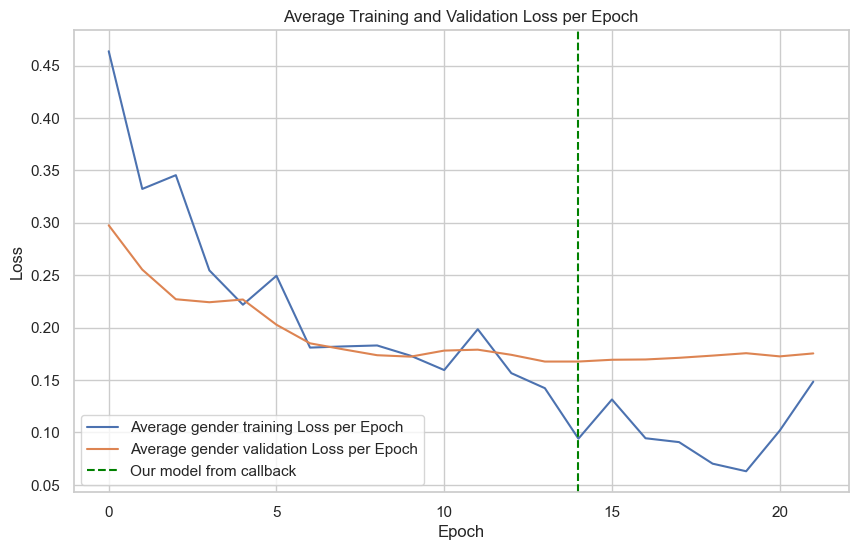

In [44]:
epoch_avg = data.groupby('epoch').mean()

plt.figure(figsize=(10, 6))
plt.plot(epoch_avg.index, 
         epoch_avg['train_gender_loss'], 
         label='Average gender training Loss per Epoch')

plt.plot(epoch_avg.index, 
         epoch_avg['val_gender_loss'],
         label='Average gender validation Loss per Epoch')

plt.axvline(x=14, 
            color='green', 
            linestyle='--', 
            label='Our model from callback')

plt.title('Average Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

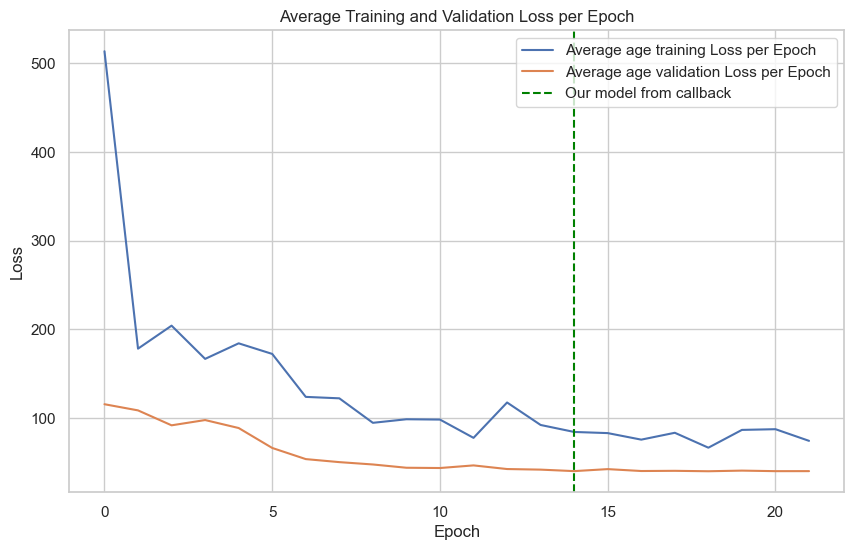

In [45]:
epoch_avg = data.groupby('epoch').mean()

plt.figure(figsize=(10, 6))
plt.plot(epoch_avg.index,
         epoch_avg['train_age_loss'],
         label='Average age training Loss per Epoch')

plt.plot(epoch_avg.index,
         epoch_avg['val_age_loss'],
         label='Average age validation Loss per Epoch')

plt.axvline(x=14,
            color='green',
            linestyle='--',
            label='Our model from callback')

plt.title('Average Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

From this graph we can observe that training curve is trending down, but its
 values is bigger than validation curve. That might be because of loss 
 calculation MSE, and training data had more outliers. We can not see 
 validation curve increase, so we assume out model is not overfitted. 

# Model evaluation

In this part we are going to make model evaluation metrics. Make some 
insights about our predictions and data.

At first we have to make function, for model predictions. And get list of 
relevant metrics for insights.

In [48]:
def evaluate_metrics(model: pl.LightningModule, test_loader: DataLoader) -> tuple:
    """
    Evaluate various metrics for the given model on the test dataset.

    Parameters:
    model (pytorch_lightning.LightningModule): The model to be evaluated.
    test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
    tuple: A tuple containing the following metrics:
        - age_mse (float): Mean Squared Error for age predictions.
        - age_mae (float): Mean Absolute Error for age predictions.
        - gender_acc (float): Accuracy for gender predictions.
        - gender_prec (float): Precision for gender predictions.
        - gender_f1 (float): F1 Score for gender predictions.
        - gender_auc (float): Area Under the ROC Curve for gender predictions.
        - all_gender_preds (list): List of all gender predictions.
        - all_gender_labels (list): List of all gender labels.
    """
    model.eval()
    age_mse_vals, age_mae_vals = [], []
    gender_acc_vals, gender_prec_vals = [], []
    gender_f1_vals, gender_auc_vals = [], []
    all_gender_preds, all_gender_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            gender_labels = labels[:, 0]
            age_labels = labels[:, 1]

            images = images.to(model.device)
            gender_labels = gender_labels.to(model.device).float()
            age_labels = age_labels.to(model.device).float()

            gender_preds, age_preds = model(images)
            age_preds = age_preds.view(-1).cpu()
            gender_preds = gender_preds.view(-1).cpu()

            all_gender_preds.extend(gender_preds > 0.5)
            all_gender_labels.extend(gender_labels.cpu())

            # Accumulate metrics
            age_mse_vals.append(mean_squared_error(age_labels.cpu(), 
                                                   age_preds))
            age_mae_vals.append(mean_absolute_error(age_labels.cpu(), 
                                                    age_preds))
            gender_acc_vals.append(accuracy_score(gender_labels.cpu(), 
                                                  gender_preds > 0.5))
            gender_prec_vals.append(precision_score(gender_labels.cpu(), 
                                                    gender_preds > 0.5))
            gender_f1_vals.append(f1_score(gender_labels.cpu(), 
                                           gender_preds > 0.5))
            gender_auc_vals.append(roc_auc_score(gender_labels.cpu(), 
                                                 gender_preds))

    # Average the metrics over all batches
    age_mse = sum(age_mse_vals) / len(age_mse_vals)
    age_mae = sum(age_mae_vals) / len(age_mae_vals)
    gender_acc = sum(gender_acc_vals) / len(gender_acc_vals)
    gender_prec = sum(gender_prec_vals) / len(gender_prec_vals)
    gender_f1 = sum(gender_f1_vals) / len(gender_f1_vals)
    gender_auc = sum(gender_auc_vals) / len(gender_auc_vals)

    return (age_mse, age_mae, gender_acc, gender_prec, gender_f1, gender_auc,
            all_gender_preds, all_gender_labels)

In [49]:
# Load results of previous tests of architectures
results_df = pd.read_csv('results.csv')

# Evaluate the model
evaluated_metrics = evaluate_metrics(model, test_loader)
age_mse, age_mae, gender_acc, gender_prec, gender_f1, gender_auc, \
                    all_gender_preds, all_gender_labels = evaluated_metrics


new_row = pd.DataFrame([{
    'model': 'run10_facenet_final_dynLR_bs16',
    'age_mse': age_mse,
    'age_mae': age_mae,
    'gender_acc': gender_acc,
    'gender_prec': gender_prec,
    'gender_f1': gender_f1,
    'gender_auc': gender_auc 
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df.to_csv('results.csv', index=False)
results_df


model     age_mse    age_mae  gender_acc  \
0                           model  381.328697  15.355766    0.849941   
1                         model_1  421.614026  16.453466    0.843062   
2                         model_3  351.206899  14.629742    0.865173   
3                         model_2   62.498135   5.579674    0.907921   
4                         model_4  142.264048   9.040000    0.880700   
5                         model_5   70.841802   6.055323    0.905562   
6  run10_facenet_final_dynLR_bs16   42.793084   4.713528    0.939465   

   gender_prec  gender_f1  gender_auc  
0     0.838282   0.838335         NaN  
1     0.931429   0.803016         NaN  
2     0.946853   0.833410         NaN  
3     0.928857   0.893337         NaN  
4     0.913230   0.861205         NaN  
5     0.953854   0.888231         NaN  
6     0.957310   0.929190    0.986568

1. **Age Prediction Accuracy**: This model shows the lowest Mean Squared Error 
(MSE) and Mean Absolute Error (MAE) for age prediction among all listed models. 
With an MSE of approximately 42.79 and an MAE of about 4.71, it indicates a 
high level of accuracy in predicting ages. 

2. **Gender Prediction Performance**: It also was the best in gender 
prediction, achieving the highest accuracy (93.95%) and precision (95.73%) 
among the models. This suggests that it's highly effective at correctly 
identifying gender and has a low rate of false positives.

3. **F1 Score**: The F1 score, which balances precision and recall, is high at 
92.92%. This further confirms the model's strong performance in gender 
classification.

4. **AUC (Area Under the Curve)**: The model achieves an impressive AUC of 
98.66%, showcasing its exceptional ability to differentiate between gender classes.

To better visualize results, we have to make confusion matrix and 
classification report.

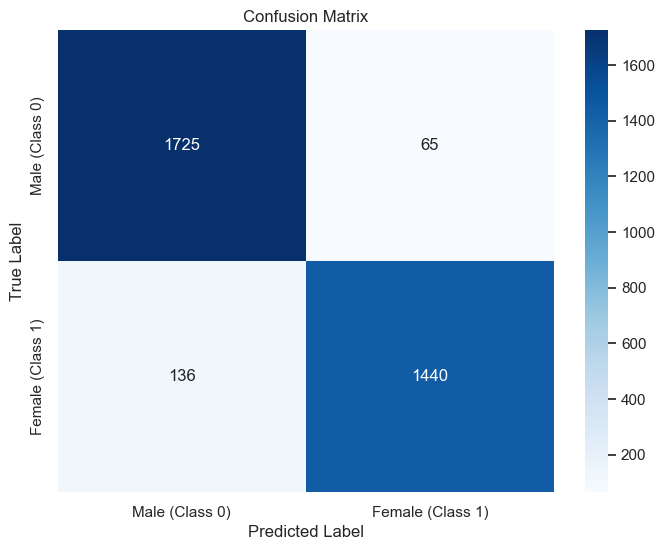

Classification Report:
                  precision    recall  f1-score   support

  Male(Class 0)       0.93      0.96      0.94      1790
Female(Class 1)       0.96      0.91      0.93      1576

       accuracy                           0.94      3366
      macro avg       0.94      0.94      0.94      3366
   weighted avg       0.94      0.94      0.94      3366


In [55]:
cm = confusion_matrix(all_gender_labels, all_gender_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Male (Class 0)', 'Female (Class 1)'],
            yticklabels=['Male (Class 0)', 'Female (Class 1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(all_gender_labels, 
                               all_gender_preds, 
                               target_names=['Male(Class 0)','Female(Class 1)'])
print("Classification Report:\n", report)

For further investigation we have to make a function to get dataframe of 
predictions and true labels of each instance in test sets. 

In [119]:
def evaluate_model(model: pl.LightningModule, test_loader: DataLoader) -> list:
    """
    Evaluate the model on the test dataset to obtain predictions for gender and age,
    along with associated confidence levels and error measures.

    Parameters:
    model (pytorch_lightning.LightningModule): The trained model to be evaluated.
    test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
    list: A list of dictionaries, where each dictionary contains:
        - 'image': The input image tensor.
        - 'true_gender': The true gender label.
        - 'predicted_gender': The predicted gender (binary).
        - 'gender_confidence_pct': Confidence percentage in the gender prediction.
        - 'true_age': The true age label.
        - 'predicted_age': The predicted age.
        - 'age_error': The absolute error in age prediction.
    """
    model.eval()
    device = next(model.parameters()).device
    results = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            gender_labels, age_labels = labels[:, 0].to(device), labels[:, 1].to(device)
            gender_pred, age_pred = model(images)
            gender_pred = torch.sigmoid(gender_pred).squeeze(1)
            age_pred = age_pred.squeeze(1)

            for i in range(images.shape[0]):
                binary_gender_pred = 1 if gender_pred[i].item() >= 0.5 else 0
                results.append({
                    'image': images[i].cpu(),
                    'true_gender': gender_labels[i].item(),
                    'predicted_gender': binary_gender_pred,
                    'gender_confidence_pct': abs(gender_pred[i].item() - 0.5) * 2 * 100,
                    'true_age': age_labels[i].item(),
                    'predicted_age': age_pred[i].item(),
                    'age_error': abs(age_pred[i].item() - age_labels[i].item())
                })

    return results

results_predictions = evaluate_model(model, test_loader)

Top gender performers


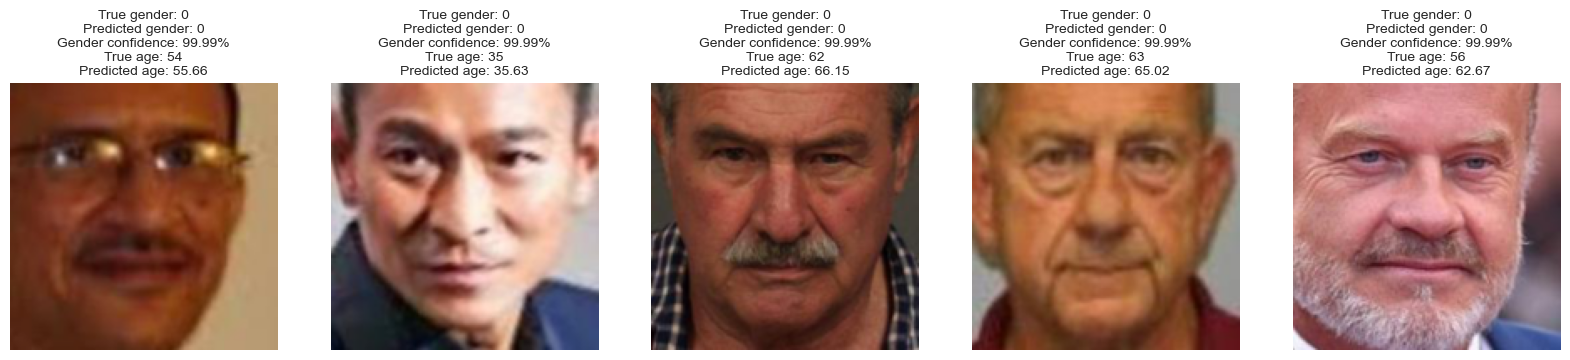

Worst gender performers


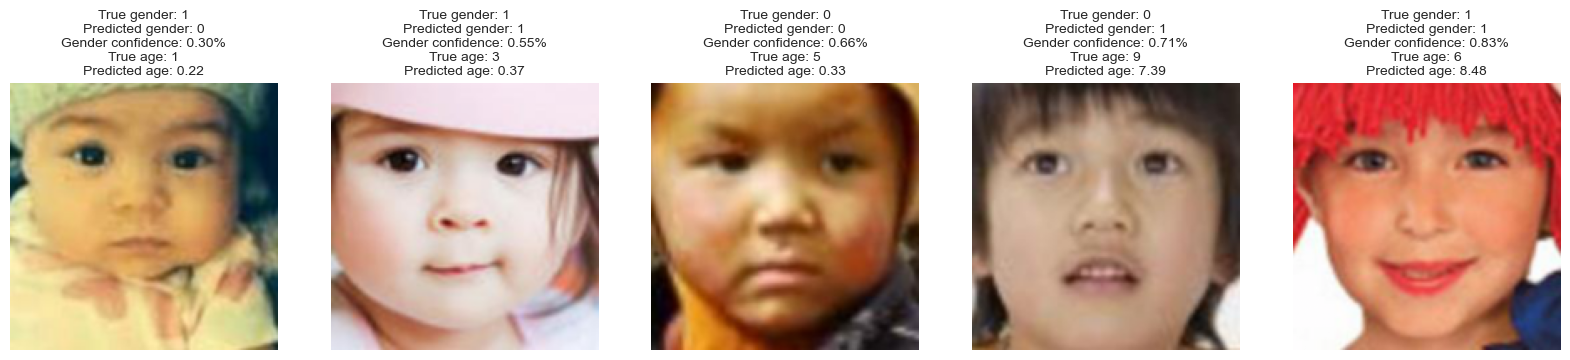

Top age performers


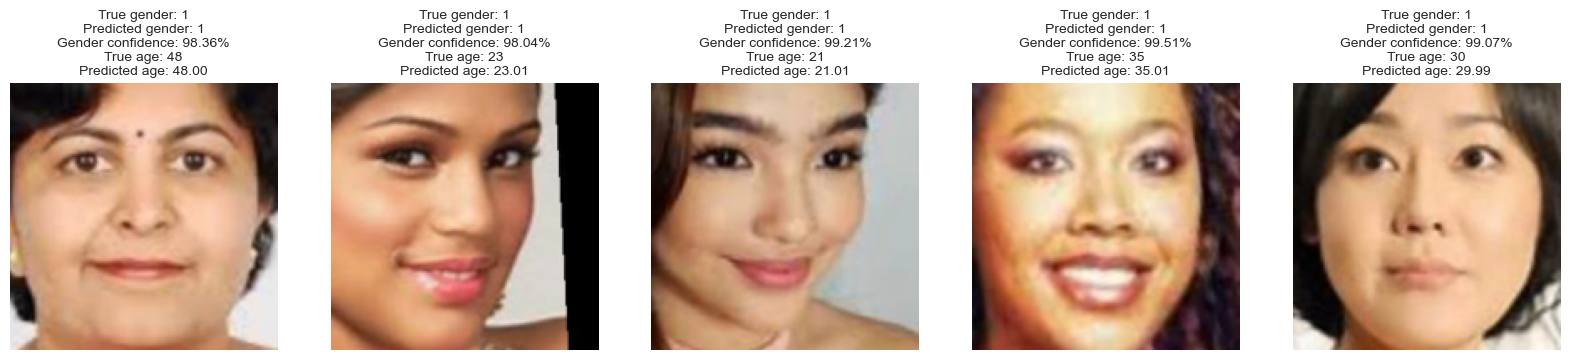

Worst age performers


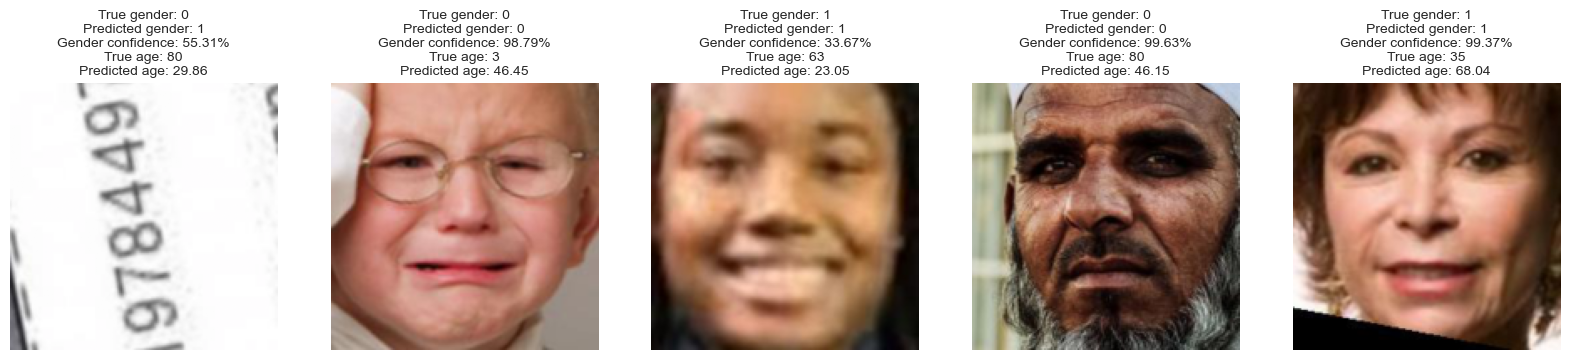

In [76]:
# Sorting and selecting top 5 for gender and age
top_gender = sorted(results_predictions, key=lambda x: x['gender_confidence_pct'], 
                    reverse=True)[:5]
top_age = sorted(results_predictions, key=lambda x: x['age_error'])[:5]
worst_gender = sorted(results_predictions, key=lambda x: x['gender_confidence_pct'])[:5]
worst_age = sorted(results_predictions, key=lambda x: x['age_error'], reverse=True)[:5]

# Function to reverse the normalization
def unnormalize(tensor: torch.Tensor) -> torch.Tensor:
    """
    Unnormalize a tensor image that was previously normalized.

    The function reverts the normalization applied to the tensor. 
    Normalization typically involves subtracting the mean and dividing by 
    the standard deviation. Unnormalization will multiply by the standard 
    deviation and then add the mean.

    Parameters:
    tensor (torch.Tensor): The normalized tensor image.

    Returns:
    torch.Tensor: The unnormalized tensor image.

    Note:
    This unnormalization is specific to certain mean and standard deviation values:
    mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
    Ensure these values are consistent with how the input tensor was originally 
    normalized.
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    return tensor

# Function to display images with all predictions and labels
def display_predictions(top_results: list) -> None:
    """
    Displays a set of prediction results for gender and age.

    Parameters:
    top_results (list): A list of dictionaries containing prediction results.
    type (str, optional): Type of prediction to display. Default is 'gender'.

    The function visualizes the top prediction results, showing both the true and predicted
    values for gender and age, along with the gender prediction confidence.
    """
    plt.figure(figsize=(20, 10))
    for i, result in enumerate(top_results):
        # Unnormalize the image
        image = unnormalize(result['image'])
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.permute(1, 2, 0).clamp(0, 1)) 
        plt.title(f"True gender: {int(result['true_gender'])}\n"
                  f"Predicted gender: {int(result['predicted_gender'])}\n"
                  f"Gender confidence: {result['gender_confidence_pct']:.2f}%\n"
                  f"True age: {int(result['true_age'])}\n"
                  f"Predicted age: {result['predicted_age']:.2f}", fontsize=10)
        plt.axis('off')
    plt.show()


print('Top gender performers')
display_predictions(top_gender)

print('Worst gender performers')
display_predictions(worst_gender)

print('Top age performers')
display_predictions(top_age)

print('Worst age performers')
display_predictions(worst_age)


- **Best performing gender predictions** we can observe that most of them are 
mens in these pictures had facial hair. This might be one of the factors in 
recognizing gender with high confidence.
- **Worst gender performers** The least accurate gender predictions were for 
children. This might be because children's faces look more similar, and it's 
easier to tell people apart as they get older
- **Top age performers** With the lowest absolute age error there are females. 
- **Worst Age Predictions** The biggest mistakes in age prediction happened in 
cases like a picture without a face, a child crying (which may look like 
wrinkles), and a woman in a low-quality image.


  0%|          | 0/2000 [00:00<?, ?it/s]

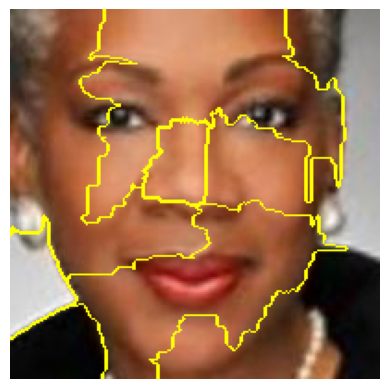

In [116]:
def model_predict(images_np: np.ndarray) -> np.ndarray:
    """
    Processes and predicts on a batch of images using a pre-trained model.

    Parameters:
    images_np (np.ndarray): An array of images in NumPy format.

    Returns:
    np.ndarray: An array of predicted probabilities. Each row corresponds to an 
                image,with two columns representing the probability of each class.

    """
    processed_images = []

    for image_np in images_np:
        image_pil = Image.fromarray(image_np.astype('uint8'), 'RGB')
        transformed_image = facenet_transform(image_pil)
        processed_images.append(transformed_image)

    images_tensor = torch.stack(processed_images).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(images_tensor)
        classification_output = predictions[0] if isinstance(predictions, tuple) else predictions
        probabilities = torch.sigmoid(classification_output).cpu().numpy()
        return np.hstack((1 - probabilities, probabilities))


test_image_path = X_test.iloc[2]
image_to_explain = np.array(Image.open(test_image_path))

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(image_to_explain, model_predict, 
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=2000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=10, 
                                            hide_rest=False)


combined_image = mark_boundaries(image_to_explain, mask)

plt.imshow(combined_image)
plt.axis('off')
plt.show();

In this picture regions highlights the parts of the image most influential for
 the model's prediction. 

## Identify how this model can be biased

This model might be biased towards certain genders or ages due to imbalanced 
data distribution. We should check for biases related to age and gender.

In [129]:
results_predictions_df = pd.DataFrame(results_predictions)
results_predictions_df = results_predictions_df.drop(columns=['image'])

results_predictions_df.head()

true_gender  predicted_gender  gender_confidence_pct  true_age  \
0            0                 0              99.384590        70   
1            1                 1              96.763301        40   
2            1                 1              99.320793        64   
3            1                 1              98.933315        85   
4            1                 1              98.784983        46   

   predicted_age  age_error  
0      57.141068  12.858932  
1      46.938820   6.938820  
2      57.062271   6.937729  
3      76.337151   8.662849  
4      40.017029   5.982971

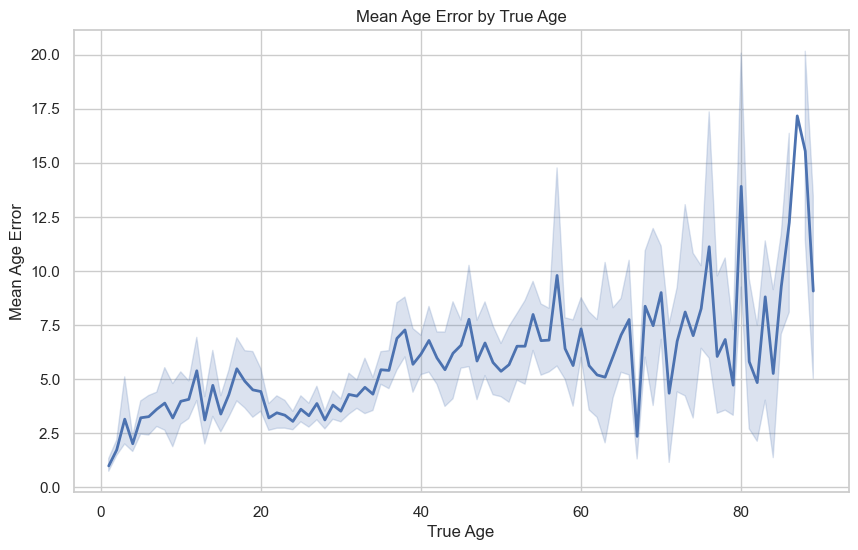

In [154]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='true_age', y='age_error', data=results_predictions_df, linewidth=2)
plt.title("Mean Age Error by True Age")
plt.xlabel("True Age")
plt.ylabel("Mean Age Error")
plt.show()

From the graph above, we can observe that the Mean Absolute Error (MAE) of age 
predictions is higher for older individuals, likely due to the smaller number 
of instances of this age group in our dataset.

C:\Users\GV\AppData\Local\Temp\ipykernel_7684\154269801.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='true_gender', y='age_error',


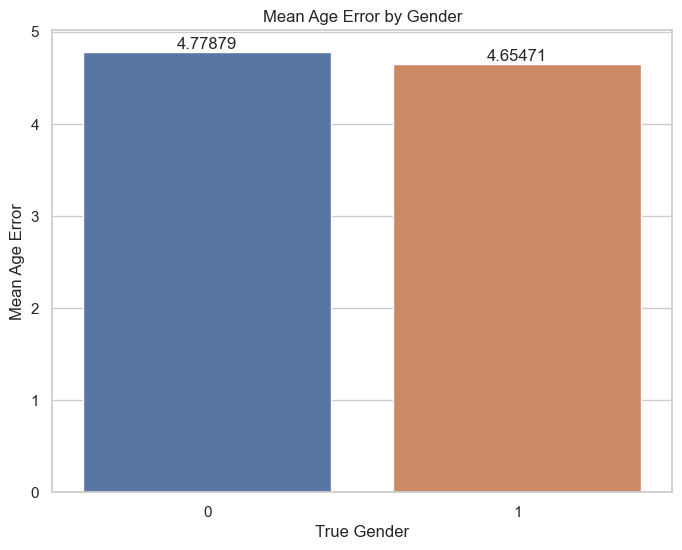

In [161]:
mean_age_error_by_gender = results_predictions_df.groupby('true_gender')['age_error'].mean().reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='true_gender', y='age_error', 
                 data=mean_age_error_by_gender, ci=None)

plt.title('Mean Age Error by Gender')
plt.xlabel('True Gender')
plt.ylabel('Mean Age Error')

ax.bar_label(ax.containers[0])
plt.show();


MAE between genders look almost the same. So we can assume that our model is 
not biased to gender.

## Where this model could/could-not be deployed.

- **Could Be Deployed:** Non-critical applications like digital marketing, 
age-based content recommendation, or general demographic analysis.
- **Could Not Be Deployed:** High-stakes decisions like employment, law 
enforcement, healthcare, or financial services, where inaccurate or biased 
predictions could have serious consequences.

## Further investigation

To enhance our predictions, we need to acquire more balanced data, particularly 
for minority classes. Do more experiments with various architectures, loss 
functions, and learning rates. We should also try more aggressive data 
augmentations. Additionally, building an ensemble of several models, each with 
distinct architectures, could be beneficial.
